Robot Dynamic Model Identification
=======
---

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time
np.warnings.filterwarnings('ignore') #omer

---
# Data processing

In [2]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')

## Load data

In [3]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [4]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'three'


model_folder = 'data/' + model_name + '/model/'
#robot_model = load_data(model_folder,model_name)
robot_model = load_data(model_folder,training_trajectory_name) #omer


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [5]:
training_trajectory_name = 'three'
results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


### Training trajectory

<Figure size 432x288 with 0 Axes>

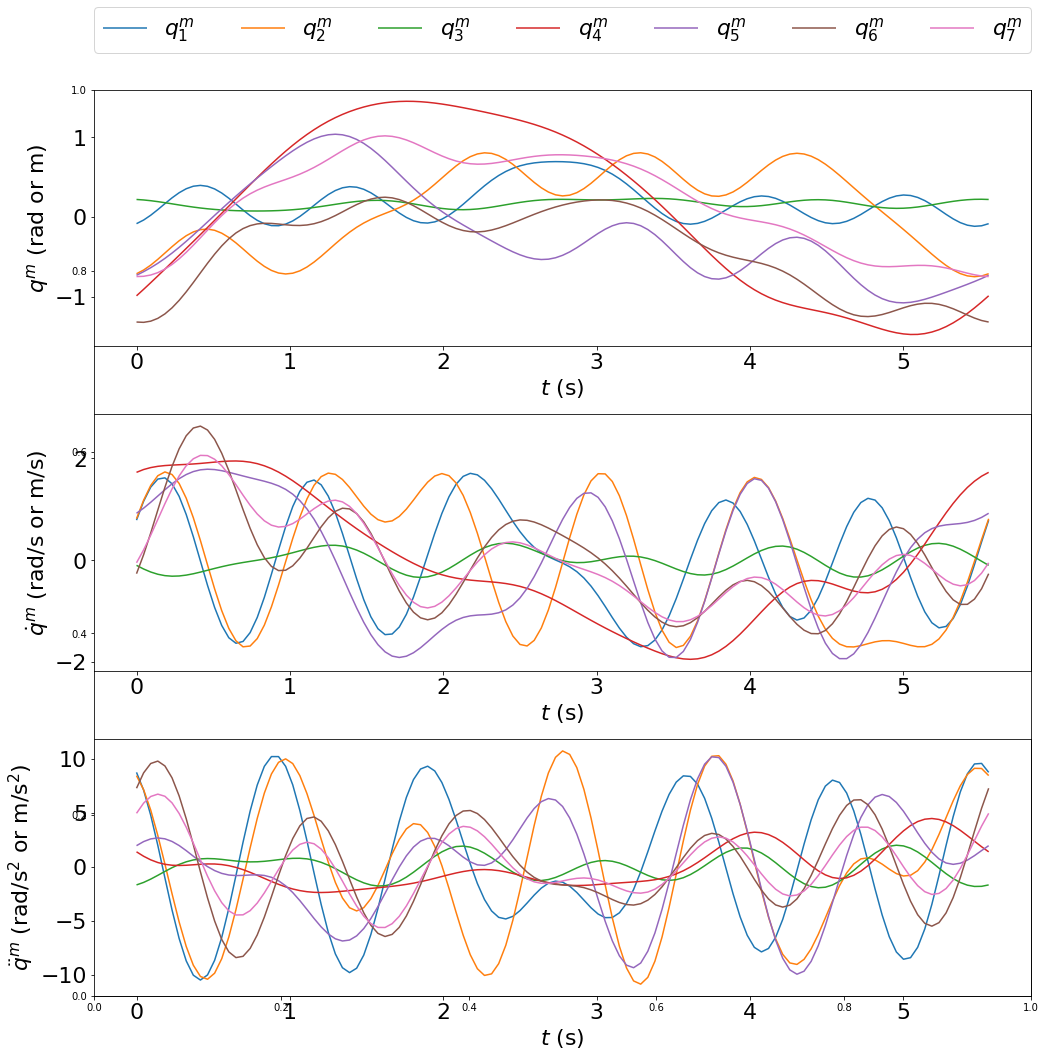

In [6]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [7]:
test_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [8]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

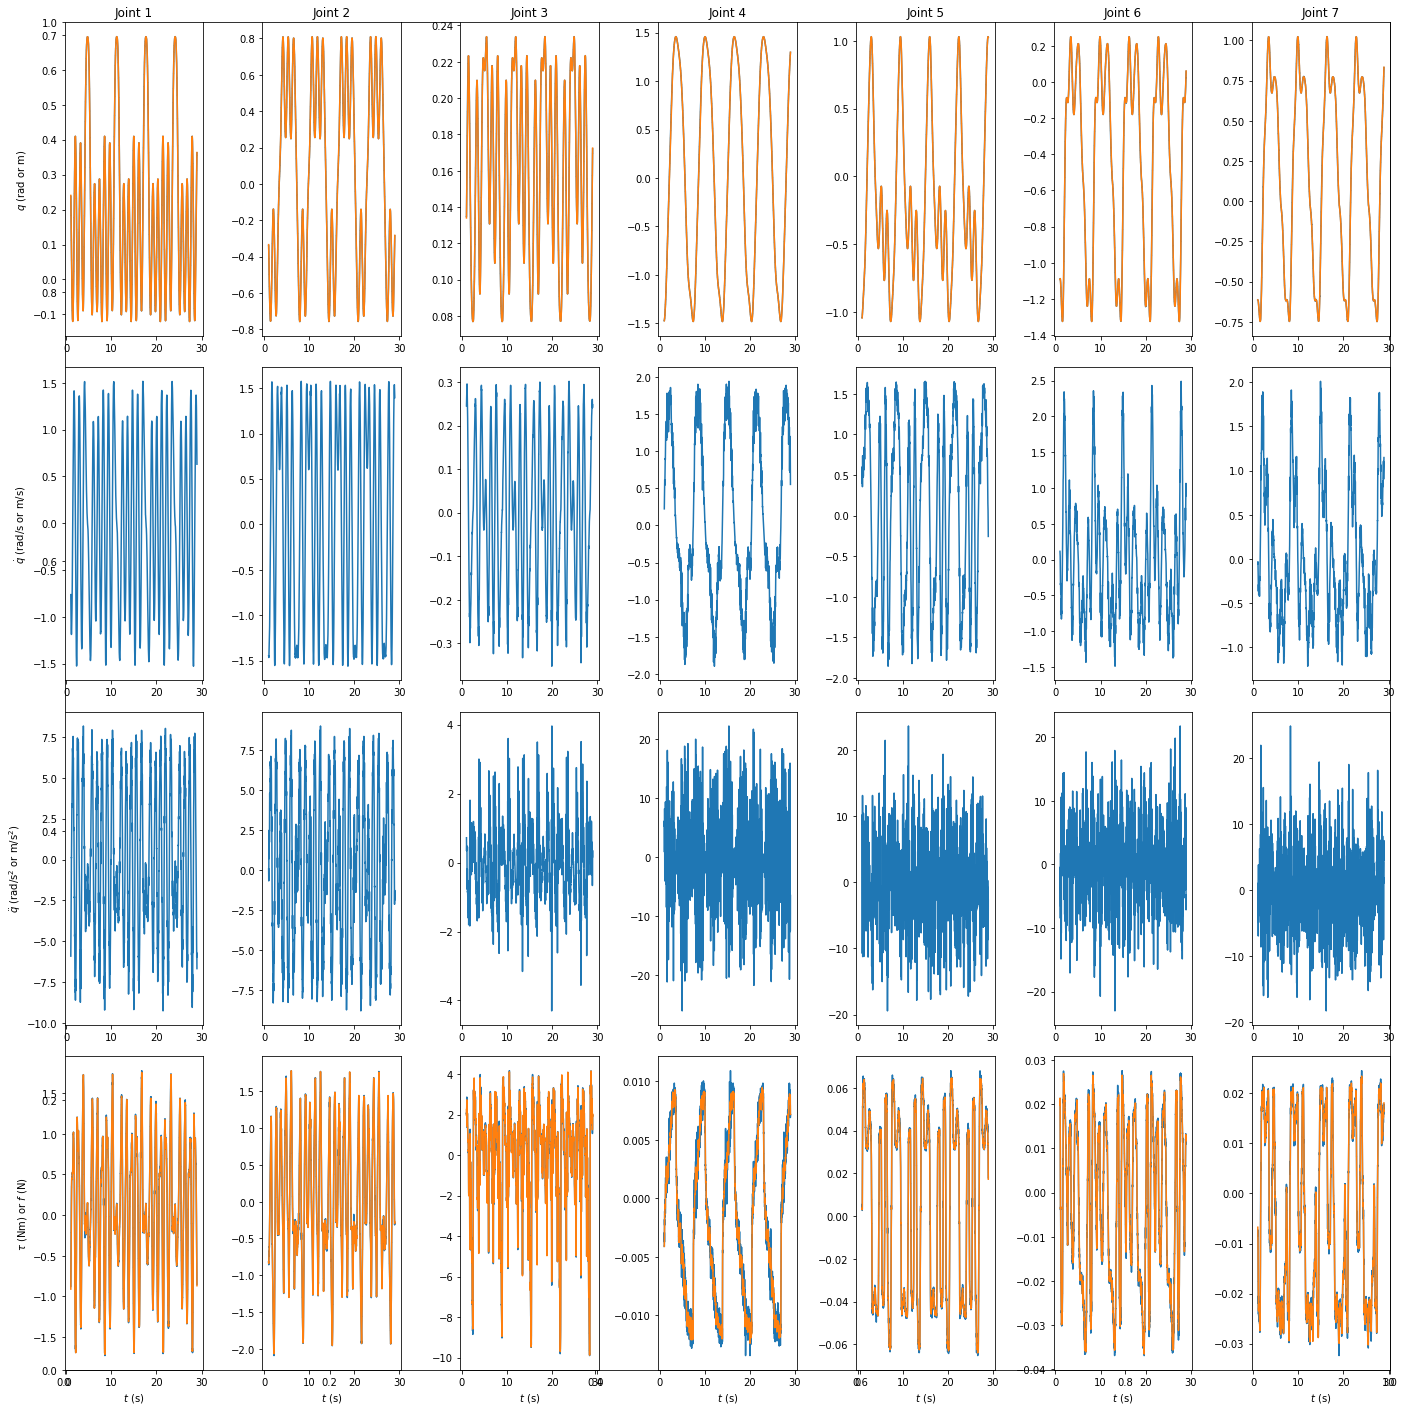

In [9]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


<Figure size 432x288 with 0 Axes>

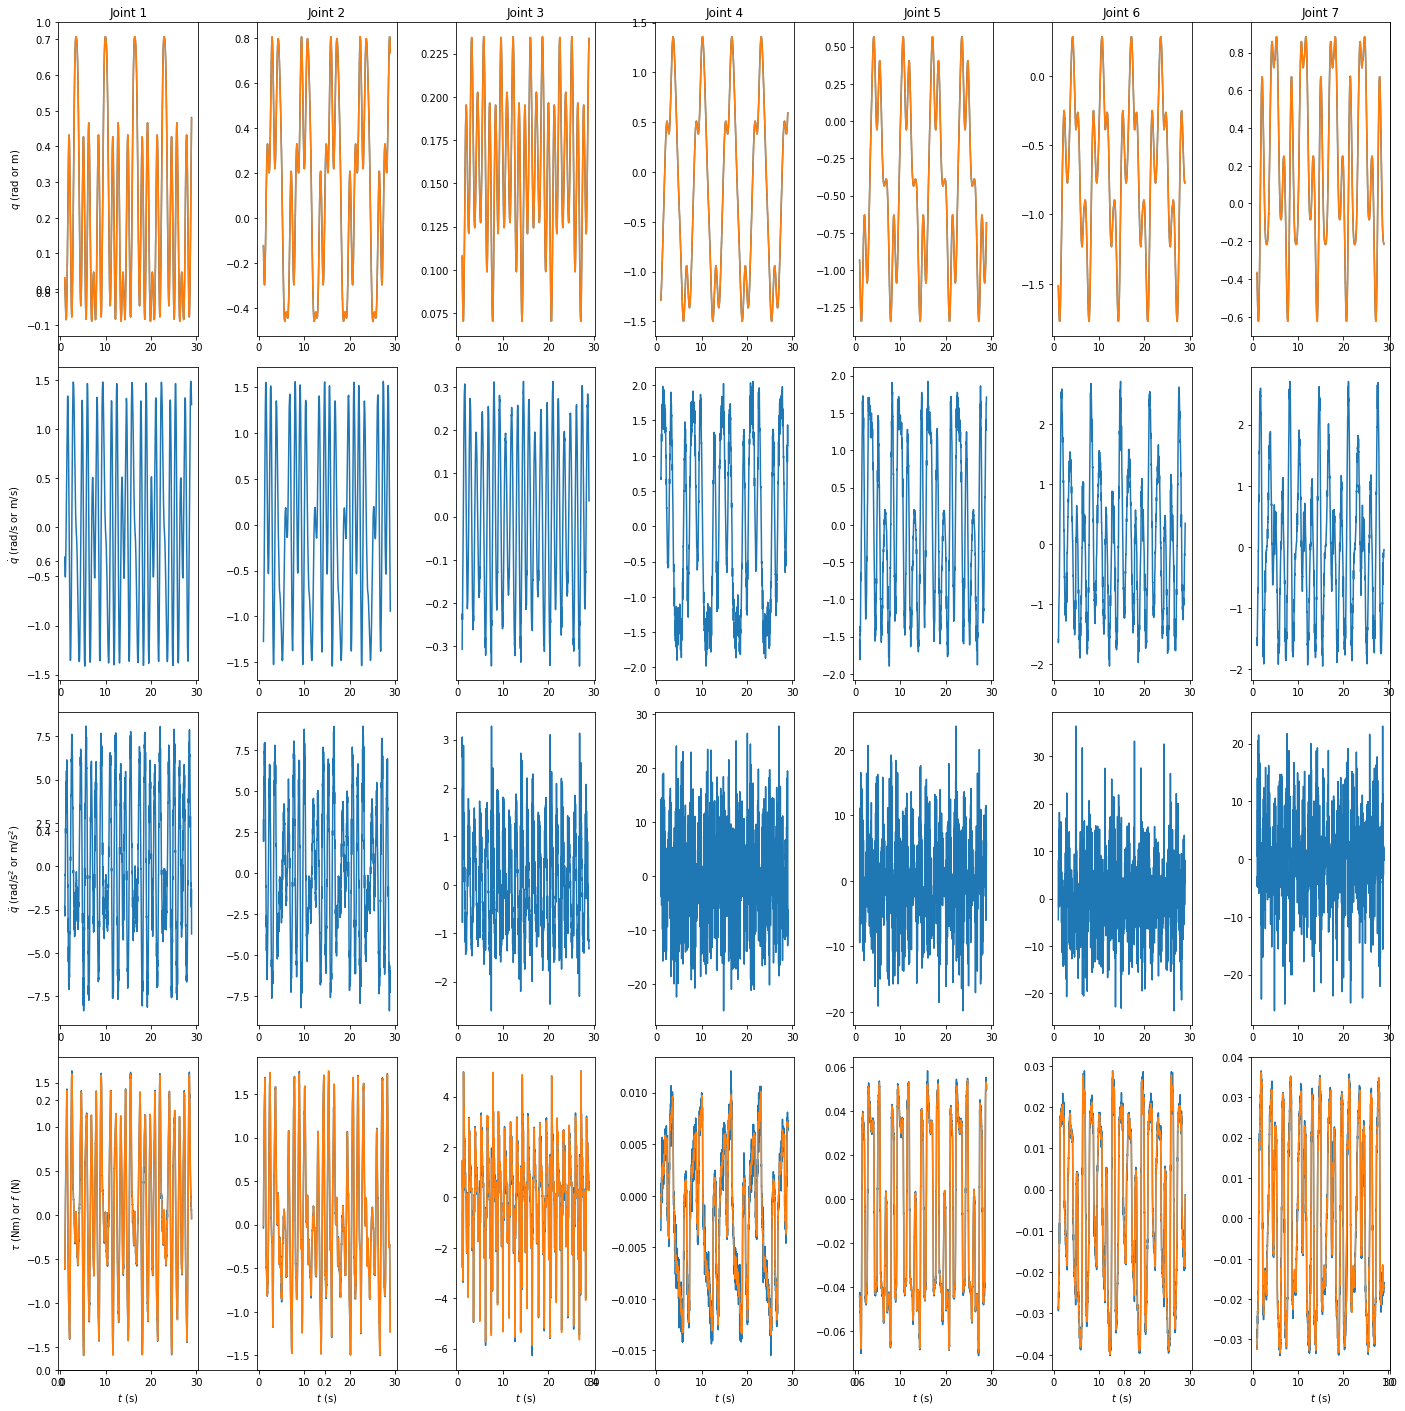

In [10]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [11]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [12]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [13]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

In [14]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 350
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [15]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [16]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0036653079731122124
standard deviation of xb using OLS:
[8.61893343e-05 1.06626450e-04 1.10254860e-04 9.12633368e-05
 1.61173992e-04 4.09421019e-04 1.43196746e-04 8.71960486e-05
 1.33539573e-04 6.83821782e-05 6.58556469e-05 6.87734921e-05
 6.91520113e-05 4.30795449e-04 1.85192350e-04 3.57034813e-04
 7.44657226e-05 2.57491988e-04 1.13418708e-04 1.11305820e-04
 2.71404880e-04 7.83121394e-05 7.67016511e-05 3.90019652e-04
 9.50077871e-05 1.19823285e-04 1.42605923e-04 1.69866029e-04
 2.98755007e-04 2.14249458e-01 2.21496491e-04 1.38926194e-03
 3.46472046e-03 1.94227489e-04 1.56353936e-03 1.81530535e-03
 1.83864296e-04 3.13259088e-04 1.08082171e-02 3.94274782e-02
 8.22763897e-04 2.20517176e-03 1.26632334e-03 1.04587739e-03
 1.78440985e-03 2.48243664e-03 1.78962319e-04 1.90188047e-04
 1.95865812e-04 2.08086178e-04 3.38359843e-04 2.10267654e-03
 1.84684824e-02 2.80611338e-03 2.10675065e-03 2.81377101e-02
 1.73428181e-03 1.50179625e-03 1.48356243e-03 2.

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.18231274443132692)
('Avarage error of joint ', 2, ': ', 0.24026776933316074)
('Avarage error of joint ', 3, ': ', 1.140964786511976)
('Avarage error of joint ', 4, ': ', 0.05510264186568849)
('Avarage error of joint ', 5, ': ', 0.11016784544896778)
('Avarage error of joint ', 6, ': ', 0.11438754140280602)
('Avarage error of joint ', 7, ': ', 0.05211056147382719)
('Avarage of error: ', 0.27075912720967904)


<Figure size 432x288 with 0 Axes>

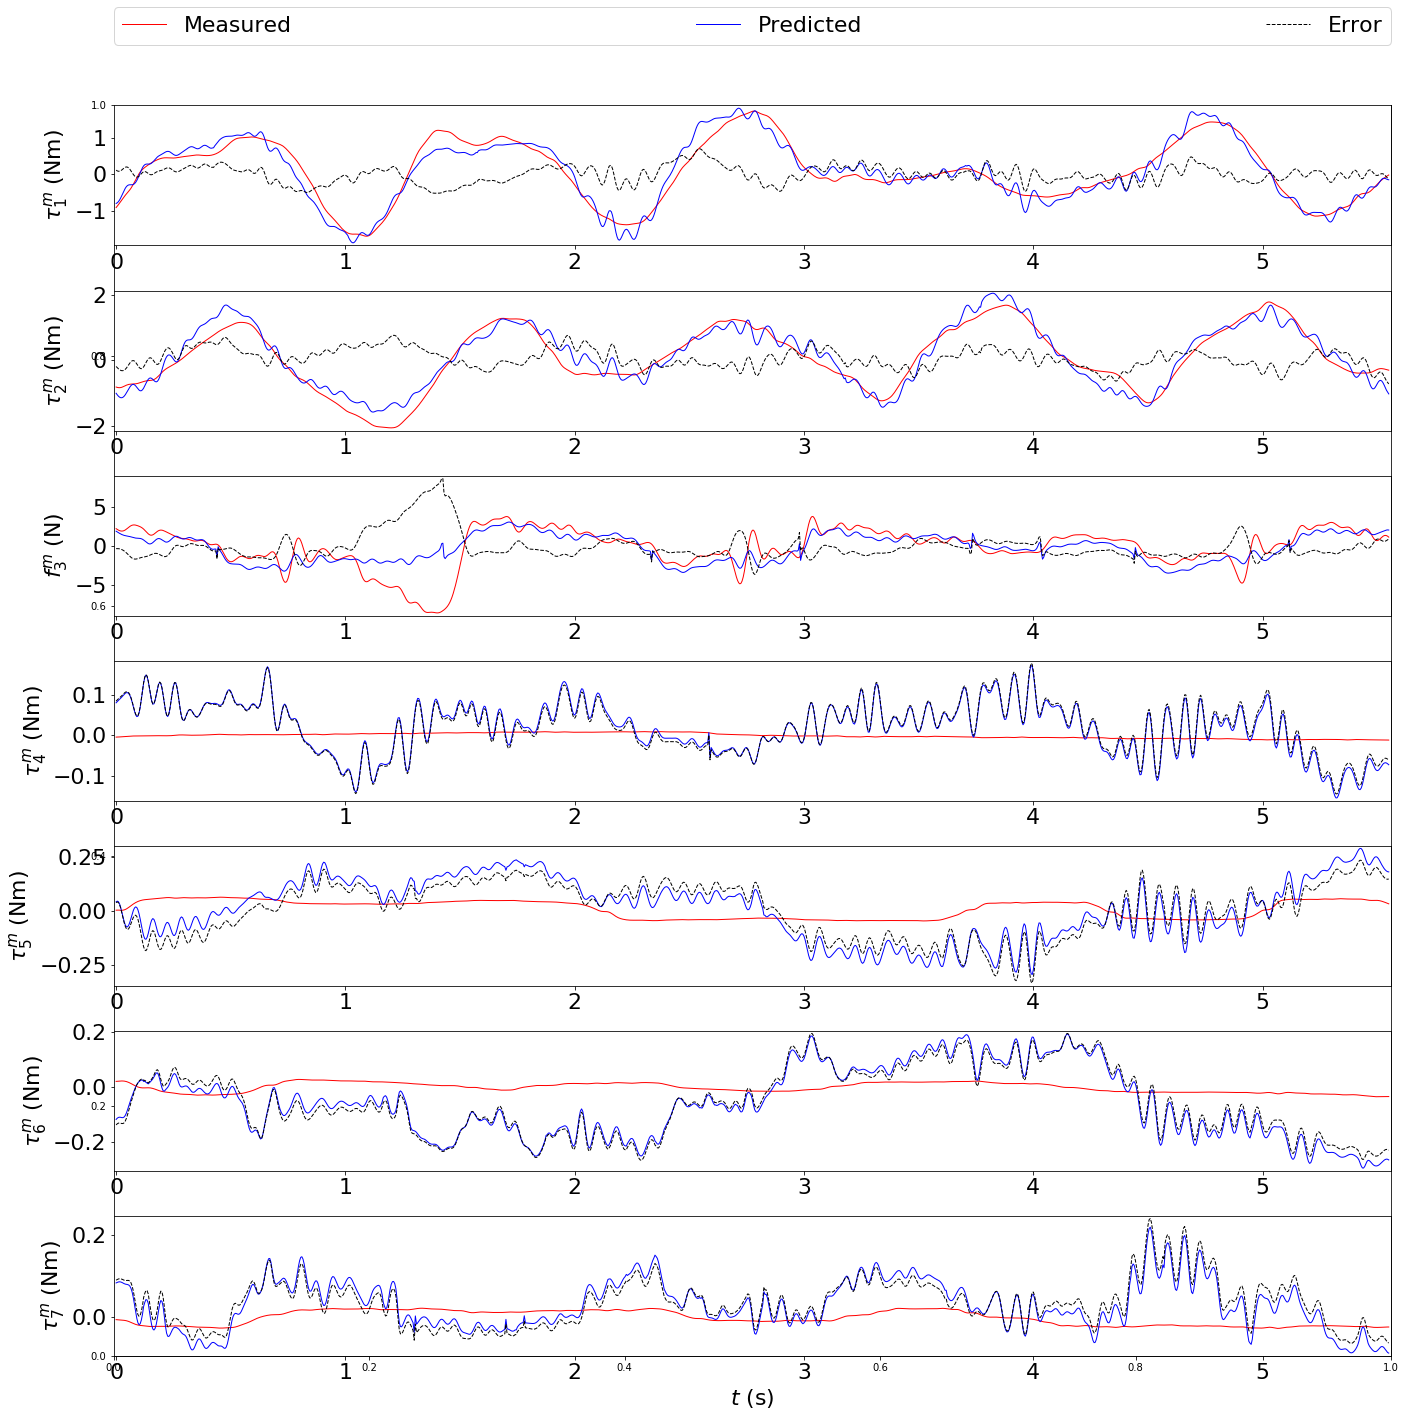

In [17]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [18]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

('Avarage error of joint ', 1, ': ', 0.19412656675219392)
('Avarage error of joint ', 2, ': ', 0.23129579100432585)
('Avarage error of joint ', 3, ': ', 0.76706661661728)
('Avarage error of joint ', 4, ': ', 0.11639424054486941)
('Avarage error of joint ', 5, ': ', 0.10912727073287981)
('Avarage error of joint ', 6, ': ', 0.13223931070656422)
('Avarage error of joint ', 7, ': ', 0.0776651053456852)
('Avarage of error: ', 0.23255927167197124)


<Figure size 432x288 with 0 Axes>

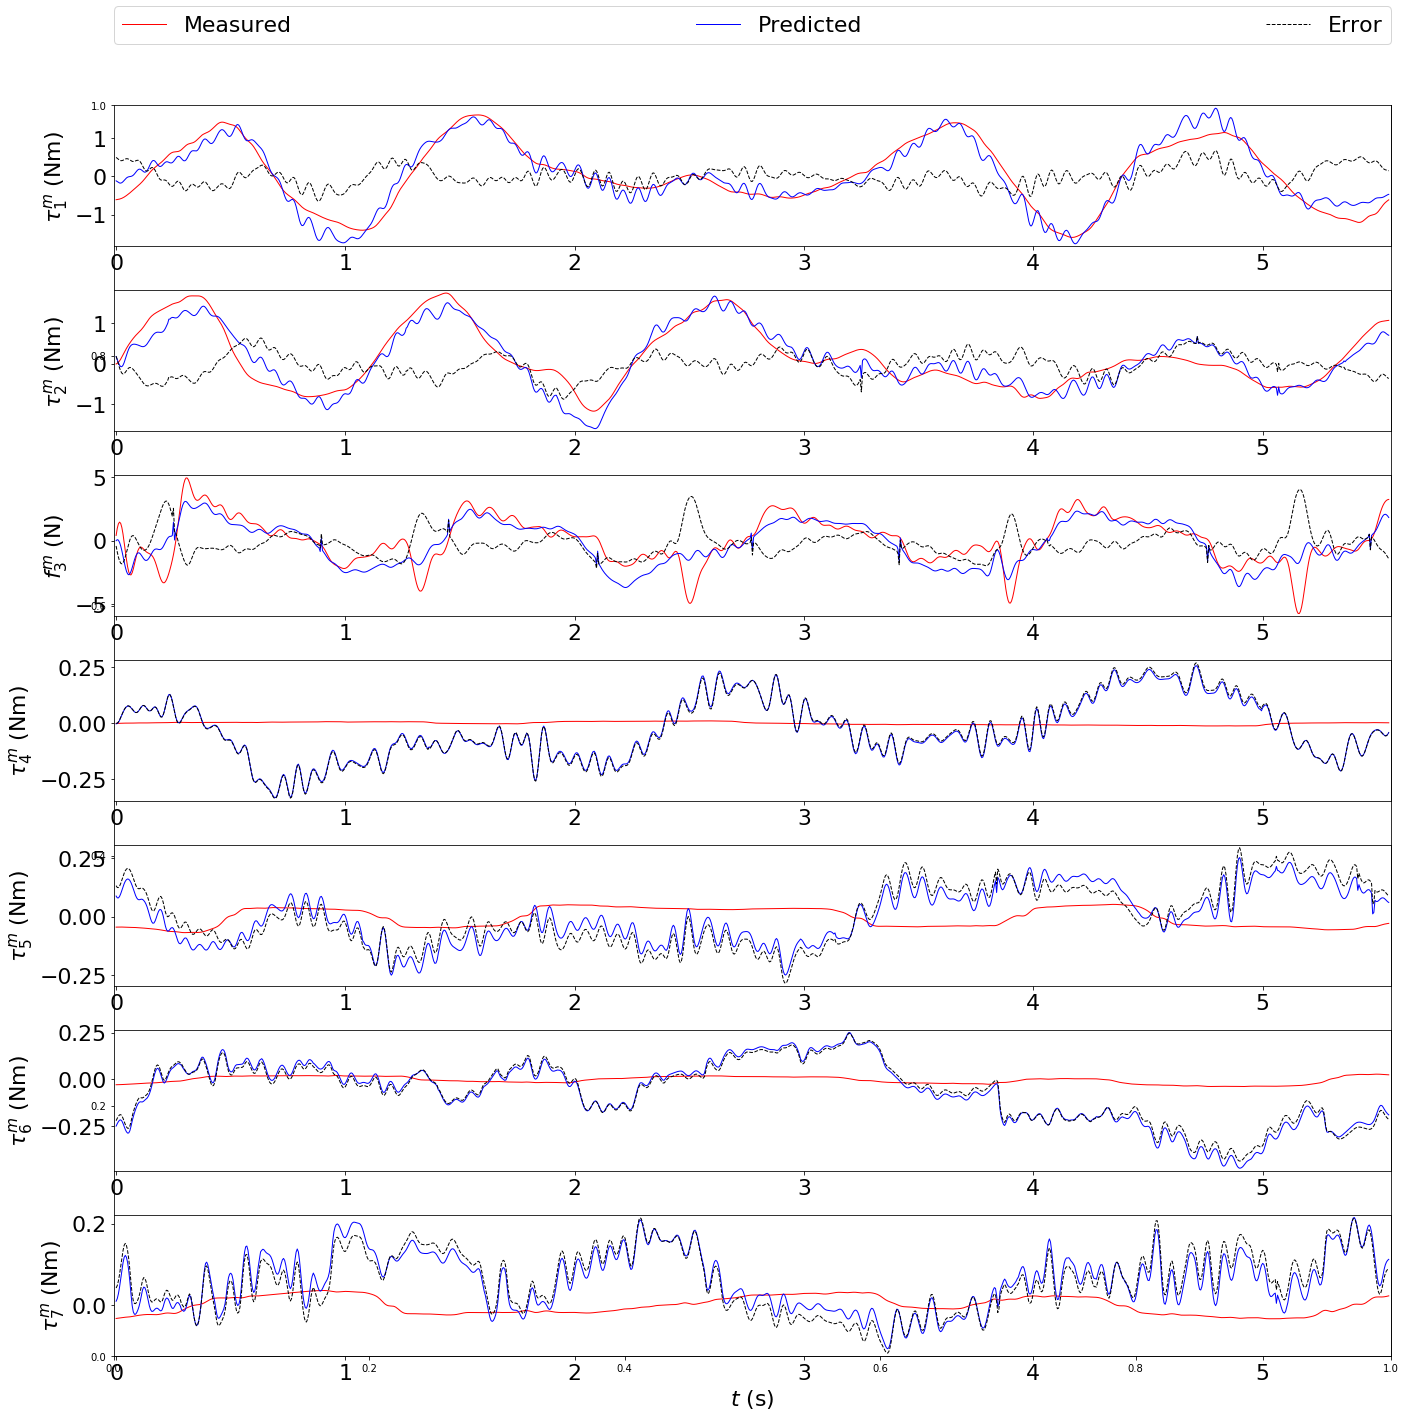

In [19]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [20]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([ 0.28963586,  0.38580237,  0.57178122, 20.95100602,  3.15823768,
        8.65097285,  4.46704999])

## Weighted Least Square (WLS)

### Training data set

In [21]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([ 3.46624225,  3.84851845, 14.03420023,  0.02185658,  0.12863678,
        0.0634664 ,  0.05368694])

In [22]:
W_b_train.shape, tau_s_train.shape

In [23]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [24]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [25]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

In [26]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [27]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

('Avarage error of joint ', 1, ': ', 0.07785789544012409)
('Avarage error of joint ', 2, ': ', 0.14593164739329345)
('Avarage error of joint ', 3, ': ', 1.144791600866656)
('Avarage error of joint ', 4, ': ', 0.0014296589293532518)
('Avarage error of joint ', 5, ': ', 0.010479986923441561)
('Avarage error of joint ', 6, ': ', 0.004623927497379447)
('Avarage error of joint ', 7, ': ', 0.004469874090407805)
('Avarage of error: ', 0.1985120844486651)


<Figure size 432x288 with 0 Axes>

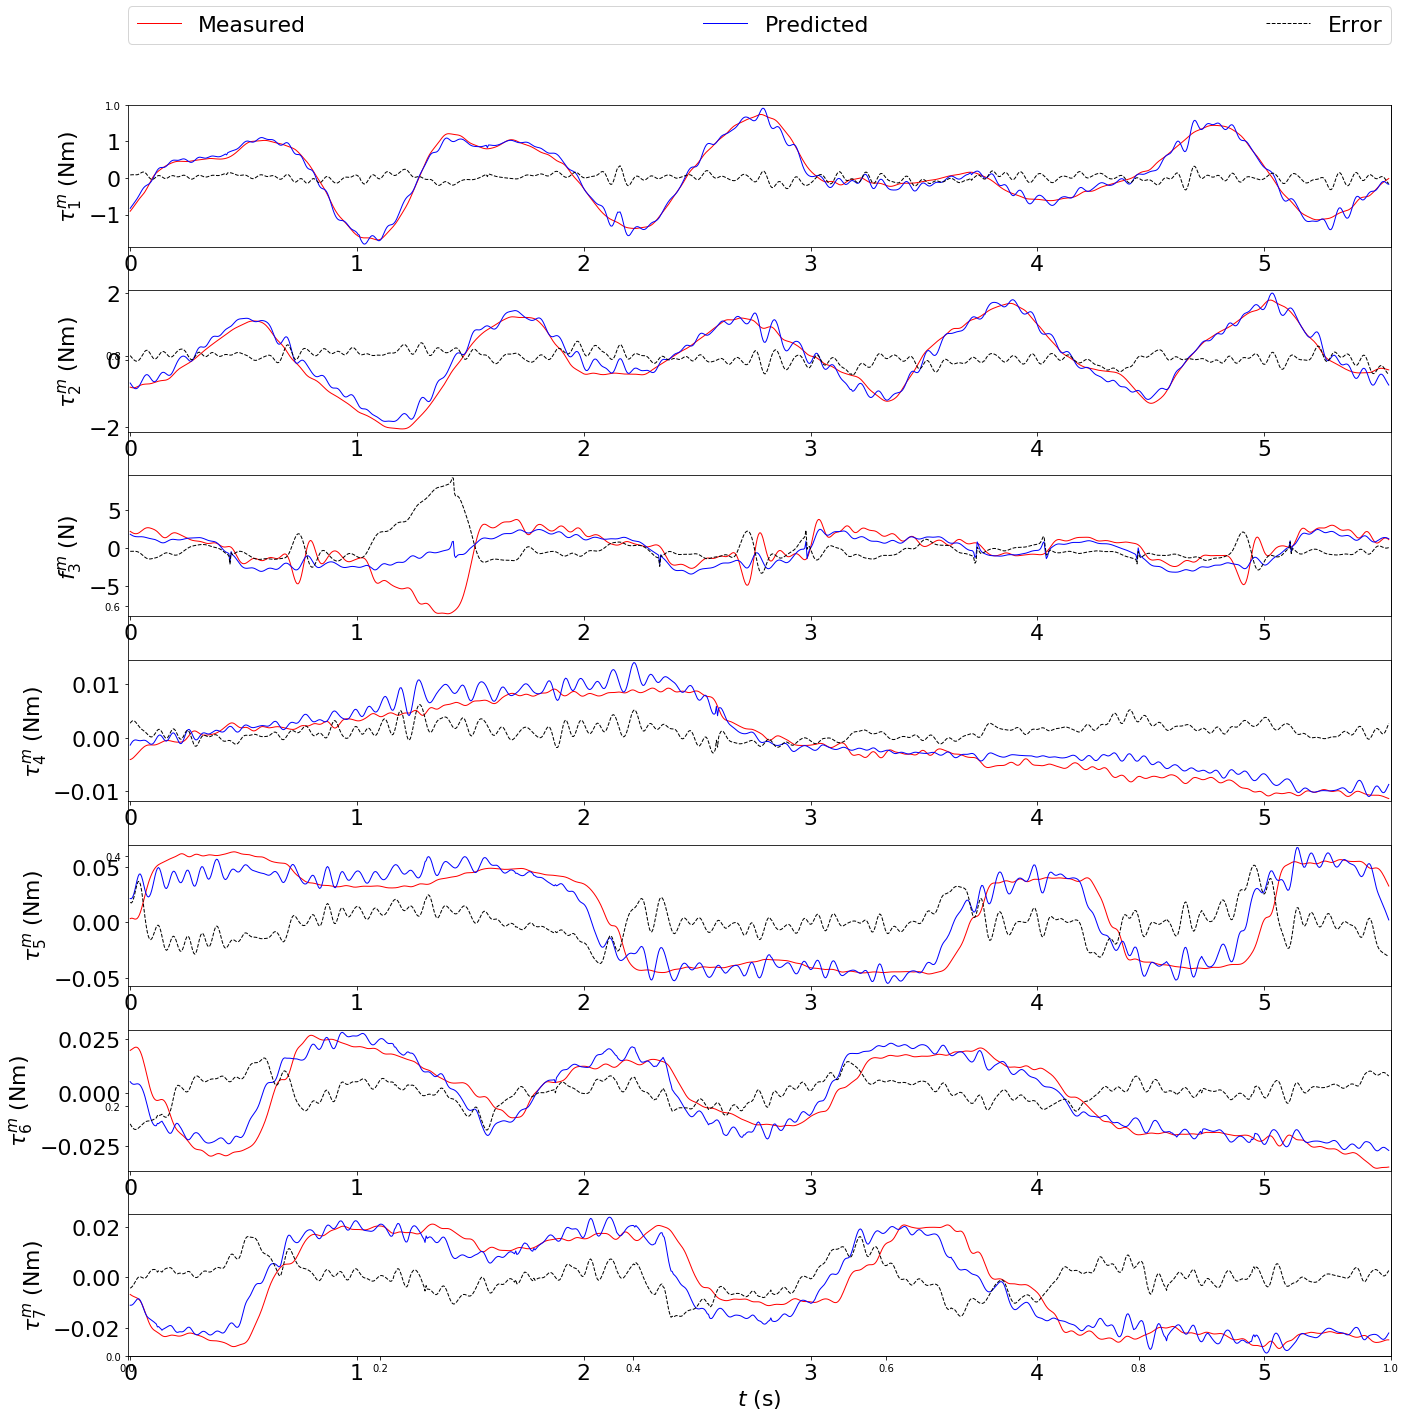

In [28]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [29]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.11970277, 0.19752347, 0.72971743, 0.29100844, 0.33613066,
       0.34109908, 0.33258661])

### Test data set

('Avarage error of joint ', 1, ': ', 0.08647459225705112)
('Avarage error of joint ', 2, ': ', 0.12888948041417655)
('Avarage error of joint ', 3, ': ', 0.843765407188375)
('Avarage error of joint ', 4, ': ', 0.002030606695730464)
('Avarage error of joint ', 5, ': ', 0.014681426199932152)
('Avarage error of joint ', 6, ': ', 0.00605873417754774)
('Avarage error of joint ', 7, ': ', 0.008062899057204437)
('Avarage of error: ', 0.1557090208557168)


<Figure size 432x288 with 0 Axes>

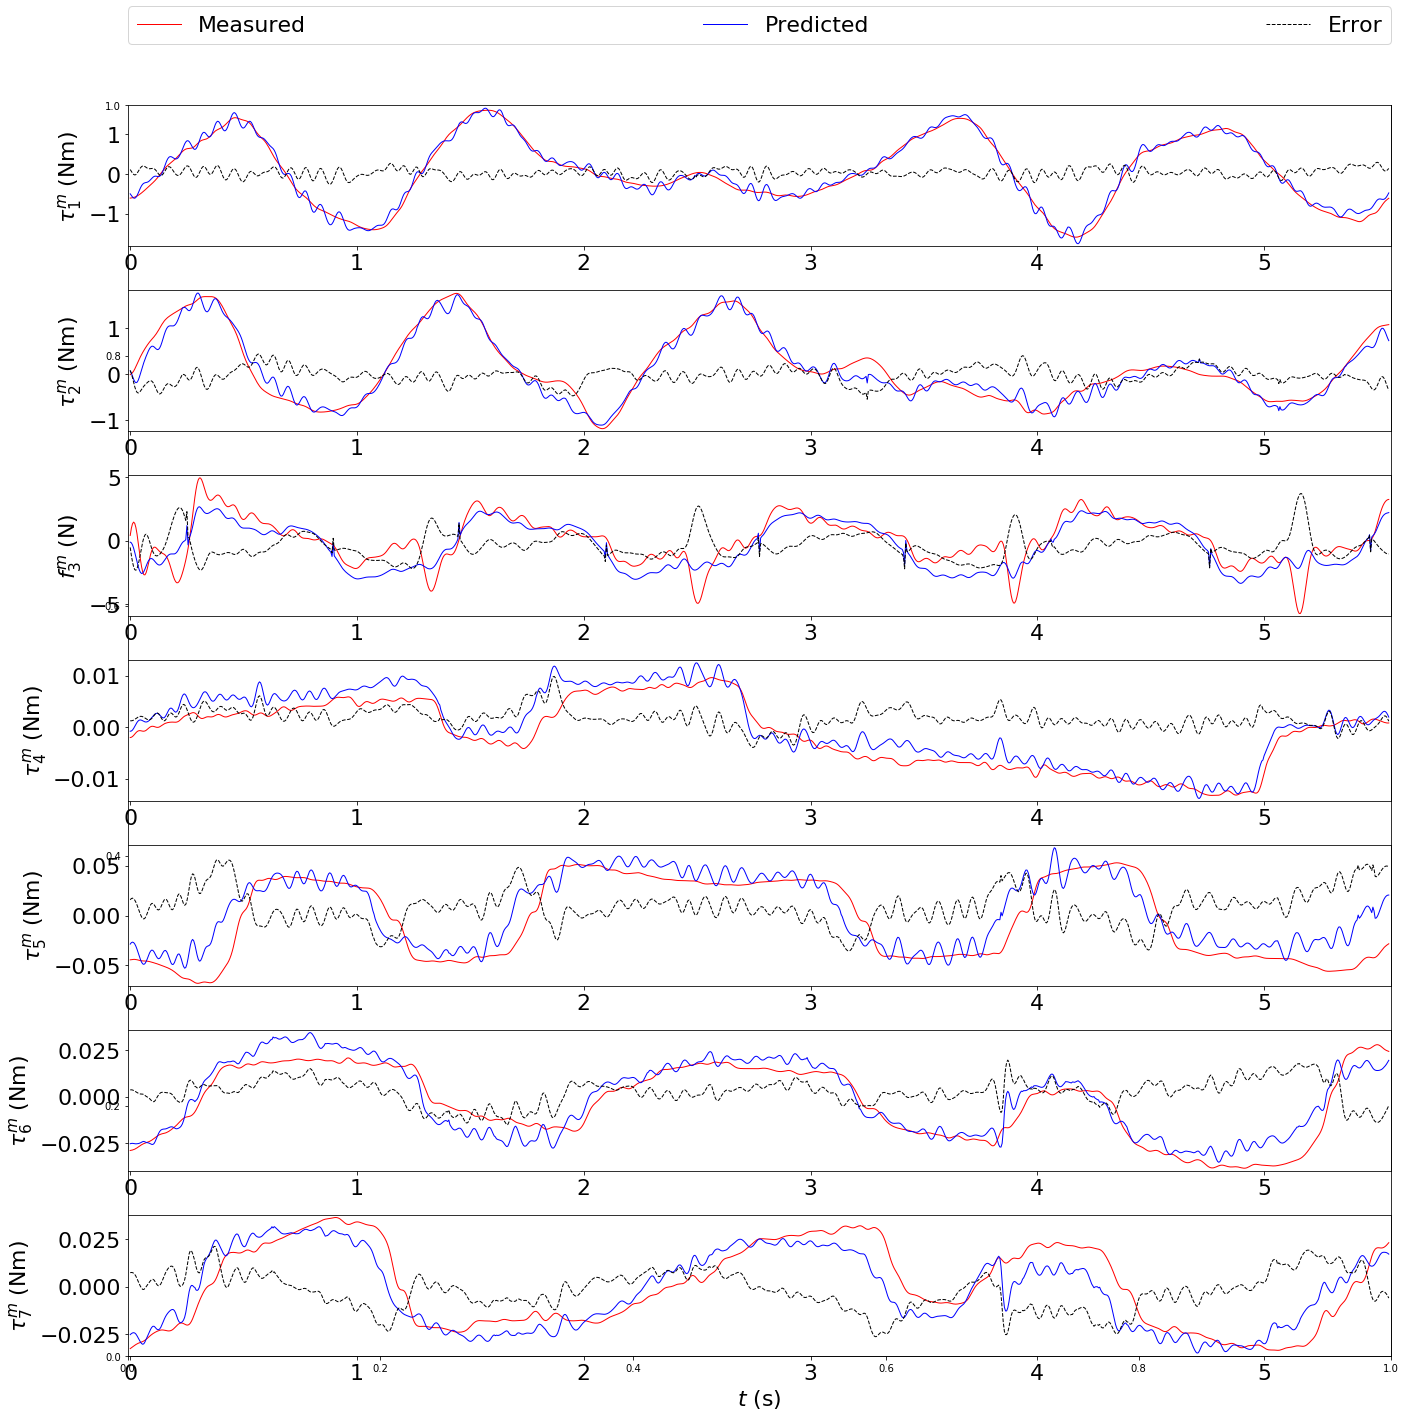

In [30]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [31]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.12618133, 0.22438073, 0.5872657 , 0.3808131 , 0.48526091,
       0.37836114, 0.47133676])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [32]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [33]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

min $m$, max $m$, min $r_x$, max $r_x$, min $r_y$, max $r_y$, min $r_z$, max $r_z$, max $F_c$, max $F_v$, max $F_o$, min $K$, max $K$

In [34]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.3, 0.5, 0.3, 1, 0, 0), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 0.3, 0.5, 0.2, 1, 0, 0),    #Pitch Back
                      (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 0.3, 0.5, 0.2, 1, 0, 0), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 0.3, 0.5, 0.2, 1, 0, 0),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.6, 2, 0.2, 1, 0, 0), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.5, 0.2, 1, 0, 0), #Counterweight
                      (0, 1, -0.05, 0.05, -0.05, 0.05, -0.1, 0.1, 0.2, 0.2, 0.2, 1, 0.0001, 1), # Wrist Roll
                      (0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Pitch
                      (0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Yaw1
                      (0, 1, -0.05, 0.05, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2, 1, 0, 0), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 1, 0, 0)] # F67
else:
    raise Exception("No robot name matches " + model_name)

In [35]:
sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model, sdp_constraints)
%time sdp_opt_std.solve(20000)

Regressor shape: (39193, 147)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1695522
eps = 1.00e-04, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 148, constraints m = 39463
Cones:	linear vars: 158
	soc vars: 39195, soc blks: 1
	sd vars: 110, sd blks: 11
Setup time: 4.28e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.64e+18  9.04e+20  1.00e+00 -4.69e+19  3.62e+20  1.4

  9300| 4.03e-03  1.15e+01  1.09e-03  1.04e+03  1.03e+03  3.44e-16  8.48e+01 
  9400| 5.72e-03  1.97e+01  4.91e-03  1.02e+03  1.03e+03  1.81e-16  8.57e+01 
  9500| 3.79e-03  6.24e+00  1.58e-03  1.04e+03  1.04e+03  6.26e-16  8.66e+01 
  9600| 2.81e-03  1.21e+01  6.76e-03  1.02e+03  1.04e+03  1.05e-15  8.75e+01 
  9700| 1.36e-03  2.36e+00  1.60e-03  1.04e+03  1.04e+03  4.46e-16  8.85e+01 
  9800| 2.33e-03  7.66e+00  1.12e-03  1.04e+03  1.04e+03  3.80e-16  8.94e+01 
  9900| 6.17e-03  1.26e+01  2.20e-03  1.04e+03  1.05e+03  9.58e-16  9.03e+01 
 10000| 1.11e-03  3.75e+00  1.63e-04  1.04e+03  1.04e+03  3.93e-16  9.12e+01 
 10100| 1.22e-03  3.43e+00  1.01e-03  1.04e+03  1.04e+03  2.15e-16  9.21e+01 
 10200| 8.84e-03  1.77e+01  7.50e-03  1.05e+03  1.06e+03  5.37e-17  9.30e+01 
 10300| 6.77e-03  1.85e+01  5.49e-04  1.02e+03  1.02e+03  4.14e-16  9.40e+01 
 10400| 2.38e-03  1.20e+01  2.63e-03  1.05e+03  1.04e+03  2.89e-16  9.49e+01 
 10500| 8.78e-04  6.72e+00  8.64e-04  1.04e+03  1.04e+03  1.48e-

 19900| 1.14e-02  3.15e+01  1.27e-02  1.09e+03  1.07e+03  7.44e-16  1.85e+02 
 20000| 1.81e-03  3.75e+00  2.42e-03  1.08e+03  1.07e+03  1.96e-17  1.86e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 1.86e+02s
	Lin-sys: nnz in L factor: 1740762, avg solve time: 6.18e-03s
	Cones: avg projection time: 1.69e-04s
	Acceleration: avg step time: 1.91e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1568e-08, dist(y, K*) = 3.8417e-09, s'y/|s||y| = 3.7451e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8128e-03
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.7521e+00
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.4219e-03
----------------------------------------------------------------------------
c'x = 1078.6924, -b'y = 1073.4777
CPU times: user 12min 17s, sys: 8.85 s, total: 12min 26s
Wall time: 3min 7s


## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [36]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [37]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.1289999 , 0.21406095, 0.8331129 , 1.04449678, 0.42400463,
       0.54153051, 0.49758963])

### Plot measured torque and predicted torque

('Avarage error of joint ', 1, ': ', 0.08339538883055811)
('Avarage error of joint ', 2, ': ', 0.1580254267304999)
('Avarage error of joint ', 3, ': ', 1.433456492523117)
('Avarage error of joint ', 4, ': ', 0.004915341503960417)
('Avarage error of joint ', 5, ': ', 0.012985019114052445)
('Avarage error of joint ', 6, ': ', 0.007403591589177451)
('Avarage error of joint ', 7, ': ', 0.006943354191579372)
('Avarage of error: ', 0.24387494492613496)


<Figure size 432x288 with 0 Axes>

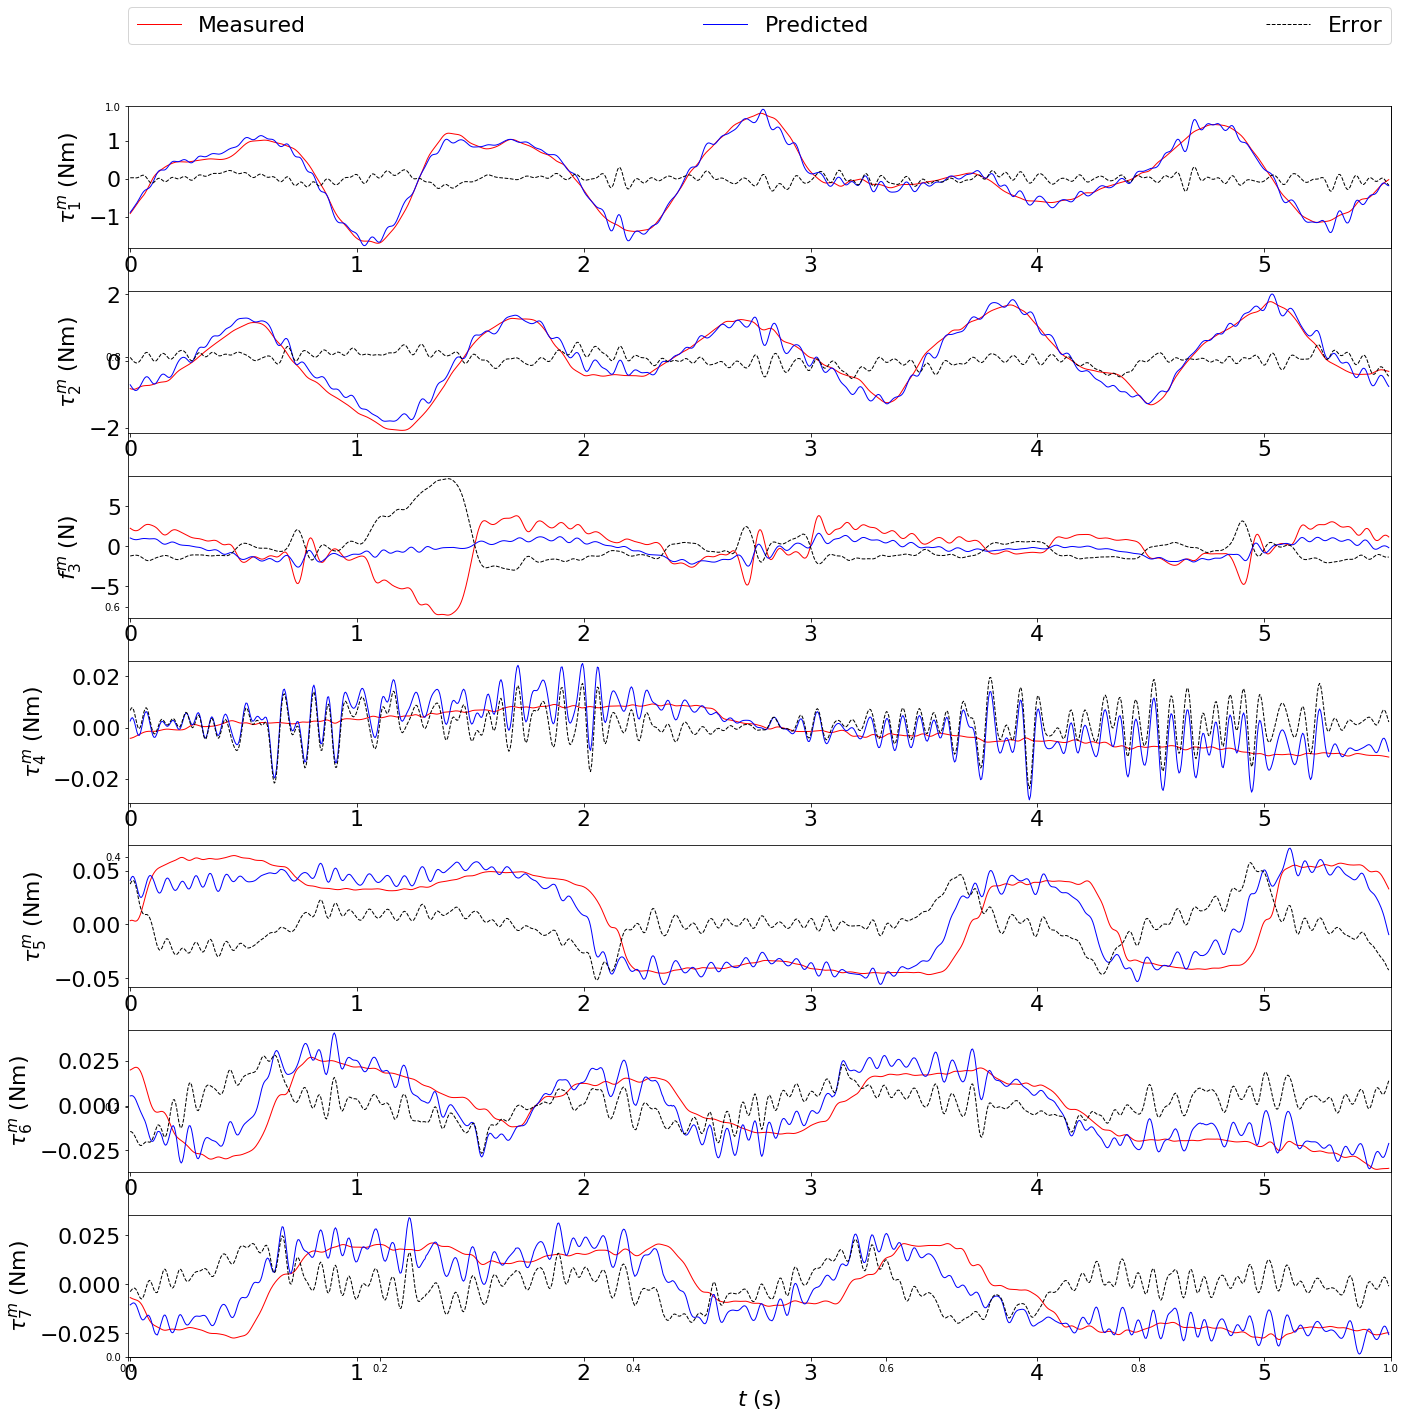

In [38]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [ ]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [ ]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [ ]:
test_plot_data_folder = 'data/' + model_name +'/test_plot_data_folder/'
test_plot_data = (t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
save_data(test_plot_data_folder, test_trajectory_name, test_plot_data)

In [ ]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

In [ ]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

### Base parameters

In [ ]:
robot_model.base_param[0,0]
subs_x_result2bary = [(sym, x) for sym, x in zip(robot_model.bary_param, sdp_opt_std.x_result)]

sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(sympy.Matrix(robot_model.base_param).subs(subs_x_result2bary)))

In [ ]:
from identification import barycentric2standard_params

In [ ]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float), decimals=7)

In [ ]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

### Write identified dynamic parameters into a JSON file

In [ ]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

In [ ]:
from identification import write_parameters2json
param_folder = 'data/' + model_name +'/dynamic_params/'
std_param_name = 'params'
std_param_name2 = training_trajectory_name
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name2)